## Node perturbation vs RDD learning

In [94]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML

from lib.lif import LIF, ParamsLIF

Populating the interactive namespace from numpy and matplotlib


In [95]:
q = 3                      #Dimension of learnt vector
dt = 0.001                 #Simulation timestep
DeltaT = 50                #Number of timebins over which learning rule is applied
tsim = 20                  #Total simulation time
T = int((tsim/dt)/DeltaT)  #Number of learning blocks
Nsims = 1                 #Number of repeated simulations
c = 0.75                   #Correlation coefficient
x_input = 0                #Input
n = 2                      #Number of neurons
sigma = 10                 #Their noise level
mu = 1                     #Threshold
tau = 1                    #Neuron timescale
eta = 1                    #Cost gradient learning rate (RDD)
epsilon = 1e7              #Weight learning rate (RDD)
epsilon_np = 1e-6           #Weight learning rate (NP)
epsilon_np_baseline = 0.001  #Weight learning rate with baseline (NP)
p = 0.1                    #Learning window
tau_s = 0.20               #Output filter timescale

N = 19
wmax = 20
wmin = 2

nsims = 1
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

B1 = 1
B2 = 2
x = .01
y = 0.1
z = 0
cost_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

w1 = 14
w2 = 7

W_rdd = np.array([w1,w2], 'float64')
W_np = W_rdd.copy()
W_np_baseline = W_np.copy()

In [96]:
#Setup neurons
params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c)
lif_rdd = LIF(params_lif, t = DeltaT)
lif_rdd.W = W_rdd
lif_rdd.x = x_input

lif_np = LIF(params_lif, t = DeltaT)
lif_np.W = W_np
lif_np.x = x_input

lif_npb = LIF(params_lif, t = DeltaT)
lif_npb.W = W_np_baseline
lif_npb.x = x_input

## Learning with RDD

In [99]:
beta_rd = np.zeros((n, T, Nsims))
W_np_trace = np.zeros((n, T, Nsims))
W_np_baseline_trace = np.zeros((n, T, Nsims))
W_rdd_trace = np.zeros((n, T, Nsims))

for idx in range(Nsims):
    count = np.zeros(n)
    print("N=%d"%idx)

    for j in range(T):
        #Simulate LIF for RDD
        print("t = %d"%j)
    
        #Probably a faster way to implement these...
        if j == 0:
            (v_raw, h_raw, _, _, u_raw) = lif_rdd.simulate(DeltaT)

        s1 = np.convolve(h_raw[0,:], exp_filter)[0:h_raw.shape[1]]
        s2 = np.convolve(h_raw[1,:], exp_filter)[0:h_raw.shape[1]]
    
        V = np.zeros((n, q))
        V_mean = np.zeros((n, q))
        
        #Break the simulation and voltage into blocks
        cost_raw = cost_fun(s1, s2)
        nB = h_raw.shape[1]/DeltaT
        hm = h_raw.reshape((n, nB, DeltaT))
        vm = v_raw.reshape((n, nB, DeltaT))
        um = u_raw.reshape((n, nB, DeltaT))
    
        u = np.max(um, 2)
        h = np.max(hm, 2)
        cost_r = cost_raw.reshape((nB, DeltaT))
        cost = np.squeeze(cost_r[:,-1])

        #Then just repeat the learning rule as before
        dV = np.zeros(V.shape)
        bt = [False, False]
        for t in range(nB):
            for k in range(n):
                if (u[k,t] > mu - p) & (u[k,t] < mu):
                    if bt[k] == False:
                        ahat = np.array([1, 0, -(u[k,t]-mu)])
                        #ahat = np.array([1, 0, 0])
                        dV[k,:] += (np.dot(V[k,:], ahat)+cost[t])*ahat                    
                        bt[k] = True
                elif (u[k,t] < mu + p) & (u[k,t] >= mu):
                    #Only do the update when firing...
                    if bt[k] == True:
                        ahat = np.array([1, (u[k,t]-mu), 0])
                        #ahat = np.array([1, 0, 0])
                        dV[k,:] += (np.dot(V[k,:], ahat)-cost[t])*ahat                                        
                        count[k] += 1
                        V[k,:] = V[k,:] - eta*dV[k,:]/(count[k]+1)
                        dV[k,:] = np.zeros((1,q))
                        bt[k] = False
                beta_rd[k,j,idx] = V[k,0]

        #At end of episode, update weights according to V for RDD
        lif_rdd.W += epsilon*np.multiply(V[:,0], mu_mean(lif_rdd.W))
        W_rdd_trace[:,j,idx] = lif_rdd.W
    
        #Simulate LIF for NP without baseline
        #(v_raw, h_raw, _, _, eligibility) = lif_np.simulate_perturbed()
        #s1 = np.convolve(h_raw[0,:], exp_filter)[0:h_raw.shape[1]]
        #s2 = np.convolve(h_raw[1,:], exp_filter)[0:h_raw.shape[1]]        
        #cost_raw = cost_fun(s1, s2)
        #cost_r = cost_raw.reshape((nB, DeltaT))
        #cost_perturbed = np.squeeze(cost_r[:,-1])                
        #lif_np.W -= epsilon_np*cost*eligibility
        #W_np_trace[:,j,idx] = lif_np.W
        
        #Simulate LIF for NP with baseline
        #(v_raw, h_raw, _, _, _) = lif_npb.simulate()
        #s1 = np.convolve(h_raw[0,:], exp_filter)[0:h_raw.shape[1]]
        #s2 = np.convolve(h_raw[1,:], exp_filter)[0:h_raw.shape[1]]        
        #cost_raw = cost_fun(s1, s2)
        #cost_r = cost_raw.reshape((nB, DeltaT))
        #cost = np.squeeze(cost_r[:,-1])                
        #(v_raw, h_raw, _, _, eligibility) = lif_npb.simulate_perturbed()
        #s1 = np.convolve(h_raw[0,:], exp_filter)[0:h_raw.shape[1]]
        #s2 = np.convolve(h_raw[1,:], exp_filter)[0:h_raw.shape[1]]        
        #cost_raw = cost_fun(s1, s2)
        #cost_r = cost_raw.reshape((nB, DeltaT))
        #cost_perturbed = np.squeeze(cost_r[:,-1])                
        #lif_npb.W -= epsilon_np_baseline*(cost_perturbed - cost)*eligibility
        #W_np_baseline_trace[:,j,idx] = lif_npb.W

N=0
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9
t = 10
t = 11
t = 12
t = 13
t = 14
t = 15
t = 16
t = 17
t = 18
t = 19
t = 20
t = 21
t = 22
t = 23
t = 24
t = 25
t = 26
t = 27
t = 28
t = 29
t = 30
t = 31
t = 32
t = 33
t = 34
t = 35
t = 36
t = 37
t = 38
t = 39
t = 40
t = 41
t = 42
t = 43
t = 44
t = 45
t = 46
t = 47
t = 48
t = 49
t = 50
t = 51
t = 52
t = 53
t = 54
t = 55
t = 56
t = 57
t = 58
t = 59
t = 60
t = 61
t = 62
t = 63
t = 64
t = 65
t = 66
t = 67
t = 68
t = 69
t = 70
t = 71
t = 72
t = 73
t = 74
t = 75
t = 76
t = 77
t = 78
t = 79
t = 80
t = 81
t = 82
t = 83
t = 84
t = 85
t = 86
t = 87
t = 88
t = 89
t = 90
t = 91
t = 92
t = 93
t = 94
t = 95
t = 96
t = 97
t = 98
t = 99
t = 100
t = 101
t = 102
t = 103
t = 104
t = 105
t = 106
t = 107
t = 108
t = 109
t = 110
t = 111
t = 112
t = 113
t = 114
t = 115
t = 116
t = 117
t = 118
t = 119
t = 120
t = 121
t = 122
t = 123
t = 124
t = 125
t = 126
t = 127
t = 128
t = 129
t = 130
t = 131
t = 132
t = 133
t = 134
t = 135
t = 136
t = 137
t 

KeyboardInterrupt: 

In [ ]:
#Estimate mean cost function from sims
N = 19
nsims = 1
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

for i in range(N):
    #print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_tmp[k,:] = cost_fun(s1, s2)
        cost2[i,j] = np.mean(cost2_tmp)

(0, 20)

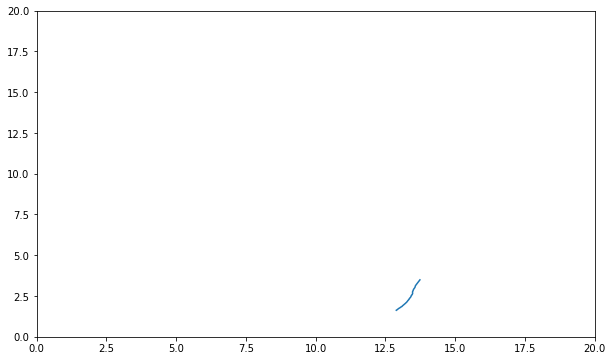

In [92]:
plt.plot(W_rdd_trace[0,:,0], W_rdd_trace[1,:,0])
plt.xlim([0, 20])
plt.ylim([0, 20])

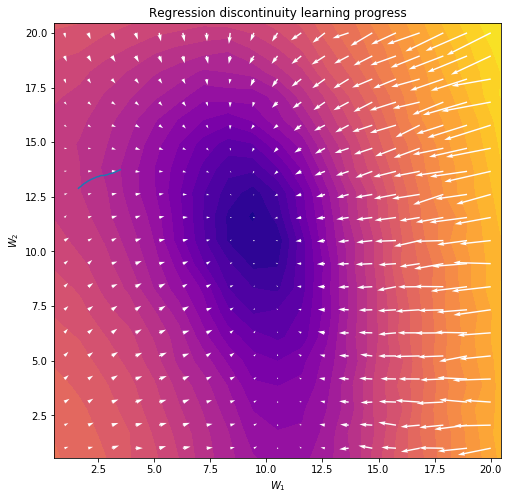

In [93]:
#Make plot of learning progress
grad = np.gradient(cost2)
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
     
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))

#Plot learning progress
ax1.plot(W_rdd_trace[1,:,0], W_rdd_trace[0,:,0])

ax1.set_title("Regression discontinuity learning progress")
ax1.set_xlabel('$W_1$')
ax1.set_ylabel('$W_2$')

In [12]:
mu1_w1 = array([[ 0.00038599,  0.00040598,  0.00039597,  0.00042193,  0.00036397,
         0.000488  ,  0.00042984,  0.00042002,  0.00043874,  0.00041903,
         0.00042666,  0.000456  ,  0.00036799,  0.00040069,  0.000388  ,
         0.00039414,  0.00048585,  0.00039574,  0.00041769],
       [ 0.00050005,  0.0005207 ,  0.00049005,  0.00051019,  0.00050673,
         0.00056246,  0.000505  ,  0.00049696,  0.0004818 ,  0.00053866,
         0.000508  ,  0.00051081,  0.00055979,  0.00047087,  0.00052298,
         0.00047997,  0.00049696,  0.000495  ,  0.00050546],
       [ 0.00068158,  0.00065558,  0.00062987,  0.00075025,  0.00069399,
         0.00068363,  0.00066428,  0.00069108,  0.00068236,  0.00070605,
         0.00069582,  0.0006529 ,  0.00068986,  0.00071986,  0.00070854,
         0.00068881,  0.00065902,  0.00069495,  0.00063837],
       [ 0.00084199,  0.00084161,  0.00080746,  0.00082982,  0.00083486,
         0.00080771,  0.00088978,  0.00091595,  0.00088368,  0.00079918,
         0.00083571,  0.00084361,  0.00087883,  0.00087306,  0.00084834,
         0.00089165,  0.00087076,  0.00086166,  0.00082482],
       [ 0.00101953,  0.00103083,  0.00098083,  0.00089556,  0.00098754,
         0.00091789,  0.00095904,  0.00089429,  0.00093192,  0.00089792,
         0.00087846,  0.00092458,  0.00098362,  0.00096864,  0.00098059,
         0.00095205,  0.00099718,  0.00093202,  0.00093931],
       [ 0.00111135,  0.00106748,  0.00114005,  0.00109796,  0.00106708,
         0.00103859,  0.00106712,  0.00108993,  0.00100918,  0.00112311,
         0.00107799,  0.00108532,  0.00099543,  0.00110689,  0.00109881,
         0.00106763,  0.00109919,  0.00109064,  0.00102853],
       [ 0.00118278,  0.00117647,  0.0012955 ,  0.0012525 ,  0.00118136,
         0.00123439,  0.00120861,  0.00137386,  0.00120989,  0.00128787,
         0.00133611,  0.00128664,  0.00123063,  0.0011746 ,  0.00125785,
         0.00121213,  0.00115176,  0.0012656 ,  0.00128238],
       [ 0.00133791,  0.00133278,  0.00134302,  0.00137175,  0.00135494,
         0.00135622,  0.00132922,  0.0011377 ,  0.00147214,  0.0012396 ,
         0.00132006,  0.00130101,  0.00131254,  0.00133562,  0.00122744,
         0.00130411,  0.00126878,  0.00128063,  0.00138525],
       [ 0.00142574,  0.00131628,  0.00127544,  0.00139871,  0.00136446,
         0.00135486,  0.00142257,  0.00130103,  0.0013225 ,  0.00140089,
         0.00136071,  0.00143726,  0.00130831,  0.0014774 ,  0.00138227,
         0.00143248,  0.00142286,  0.00136075,  0.00138667],
       [ 0.0014238 ,  0.00145456,  0.00138087,  0.00141743,  0.00140936,
         0.00142052,  0.00136963,  0.00153202,  0.00137771,  0.00143962,
         0.0015589 ,  0.00147152,  0.00146363,  0.00141913,  0.00146648,
         0.00139234,  0.00156631,  0.00151228,  0.00145267],
       [ 0.00148697,  0.00160463,  0.00166421,  0.00145639,  0.00160499,
         0.00151973,  0.00152333,  0.00156144,  0.00168855,  0.00150168,
         0.0014435 ,  0.00141151,  0.00149003,  0.00147737,  0.00154546,
         0.00155103,  0.00158634,  0.00158611,  0.00157017],
       [ 0.00151277,  0.00164954,  0.0017444 ,  0.00161395,  0.0017039 ,
         0.00162787,  0.00157896,  0.00173744,  0.00160001,  0.00169206,
         0.00155788,  0.00161477,  0.00153097,  0.00165782,  0.00173219,
         0.0017318 ,  0.00158837,  0.00155546,  0.0016032 ],
       [ 0.00171402,  0.00169213,  0.00165084,  0.00175836,  0.00169167,
         0.0018382 ,  0.00175515,  0.00172877,  0.00165181,  0.00183087,
         0.00169965,  0.00177343,  0.00183747,  0.00156226,  0.00162345,
         0.00164613,  0.0016256 ,  0.0016944 ,  0.00168483],
       [ 0.00182761,  0.00172024,  0.00174301,  0.0018124 ,  0.00179938,
         0.00177177,  0.00193176,  0.00169098,  0.00190236,  0.00165908,
         0.00175208,  0.00173567,  0.00189416,  0.0017855 ,  0.00166039,
         0.0017661 ,  0.00173364,  0.00178818,  0.00172257],
       [ 0.0017741 ,  0.00176305,  0.0017226 ,  0.00182671,  0.00190443,
         0.00165484,  0.00176612,  0.00177527,  0.0017661 ,  0.00171671,
         0.00172309,  0.00177123,  0.0018007 ,  0.00188633,  0.00176034,
         0.00177719,  0.00183588,  0.00175412,  0.00181269],
       [ 0.00193957,  0.00195359,  0.0019136 ,  0.00185922,  0.00162685,
         0.0016888 ,  0.00170052,  0.00183721,  0.0016231 ,  0.00202352,
         0.00191789,  0.00177132,  0.00171985,  0.00183247,  0.00175876,
         0.001748  ,  0.00180178,  0.00174888,  0.00179036],
       [ 0.00190472,  0.00168663,  0.00168883,  0.00173074,  0.00176623,
         0.00177844,  0.00182092,  0.00181515,  0.00179228,  0.00187271,
         0.00212044,  0.00182895,  0.00185274,  0.00188583,  0.00204558,
         0.00190887,  0.00174213,  0.0018658 ,  0.00184679],
       [ 0.0016832 ,  0.00168673,  0.00168828,  0.00168417,  0.00194335,
         0.00198359,  0.00206868,  0.00196766,  0.00196224,  0.00175316,
         0.00193861,  0.00192453,  0.00180256,  0.00170457,  0.00211544,
         0.00203783,  0.00203711,  0.00193599,  0.00195682],
       [ 0.00159163,  0.00219728,  0.00228925,  0.00183343,  0.00173962,
         0.00206308,  0.00221148,  0.00210991,  0.00209484,  0.00168756,
         0.00199206,  0.00188813,  0.00156082,  0.00166656,  0.0018655 ,
         0.00210739,  0.00239841,  0.00183418,  0.00179924]])

mu2_w2 = array([[ 0.000446  ,  0.0005415 ,  0.0006417 ,  0.00083065,  0.00097245,
         0.0010978 ,  0.0012355 ,  0.00133635,  0.0013682 ,  0.00148835,
         0.00156246,  0.00156137,  0.00168613,  0.00168277,  0.0018556 ,
         0.00179539,  0.00179137,  0.00203568,  0.00206687],
       [ 0.00043596,  0.00049673,  0.00069057,  0.00080389,  0.00098361,
         0.00115789,  0.00115075,  0.00133238,  0.00143531,  0.001472  ,
         0.00159692,  0.00149256,  0.00165679,  0.00178738,  0.0017362 ,
         0.0020496 ,  0.00191506,  0.00177167,  0.00196186],
       [ 0.00041986,  0.000486  ,  0.00068316,  0.00089213,  0.00095728,
         0.00101379,  0.00120099,  0.00127697,  0.00149165,  0.00150112,
         0.00144538,  0.00173069,  0.00156989,  0.00166823,  0.00189309,
         0.0017131 ,  0.00193331,  0.00199961,  0.00179394],
       [ 0.000444  ,  0.00047299,  0.00073453,  0.00087492,  0.00096004,
         0.00106757,  0.00112241,  0.00128519,  0.00145077,  0.00151128,
         0.00144796,  0.00160409,  0.00178974,  0.00179491,  0.00181646,
         0.00179908,  0.00171835,  0.00183679,  0.00196917],
       [ 0.00041169,  0.00050197,  0.0006853 ,  0.00081856,  0.00098908,
         0.0011578 ,  0.00122423,  0.00131625,  0.00133507,  0.0014267 ,
         0.00151246,  0.00177739,  0.00176151,  0.00162685,  0.00188322,
         0.00179539,  0.00186886,  0.00183257,  0.00157579],
       [ 0.000434  ,  0.000505  ,  0.00065568,  0.00079583,  0.00095114,
         0.00111918,  0.00113049,  0.00124464,  0.00148401,  0.00143109,
         0.00143035,  0.00165738,  0.00178069,  0.00183485,  0.00175708,
         0.00197527,  0.00194129,  0.00156736,  0.00156573],
       [ 0.00037823,  0.00050929,  0.00070817,  0.00084565,  0.00091968,
         0.00108503,  0.0013162 ,  0.00124512,  0.00137507,  0.00152976,
         0.00154014,  0.00163492,  0.00164746,  0.00178343,  0.00175251,
         0.00178416,  0.00195335,  0.00182687,  0.00168503],
       [ 0.00038137,  0.00053886,  0.0007249 ,  0.00078204,  0.00089724,
         0.00107317,  0.00132887,  0.00132812,  0.00130825,  0.00152633,
         0.00158447,  0.00162526,  0.00162231,  0.00175017,  0.00184612,
         0.00176055,  0.00191288,  0.00184918,  0.0016359 ],
       [ 0.0003761 ,  0.00053397,  0.00072272,  0.00084288,  0.00094256,
         0.00109982,  0.00110895,  0.0013349 ,  0.00145824,  0.00142183,
         0.00158015,  0.00162646,  0.00181125,  0.00162432,  0.00170776,
         0.00192503,  0.00179468,  0.00186126,  0.0019122 ],
       [ 0.0003573 ,  0.00051175,  0.00071724,  0.00080404,  0.00094574,
         0.00110788,  0.00125765,  0.00121976,  0.00140209,  0.0015708 ,
         0.00153471,  0.00148971,  0.00173317,  0.00200275,  0.00178751,
         0.00180897,  0.00176982,  0.00176937,  0.00191689],
       [ 0.00038677,  0.00049114,  0.00069791,  0.0008141 ,  0.00096087,
         0.00107936,  0.00118476,  0.00135833,  0.00134985,  0.00153053,
         0.0016002 ,  0.00154239,  0.00162691,  0.00178256,  0.00181936,
         0.0019133 ,  0.00195821,  0.00182943,  0.00189936],
       [ 0.000432  ,  0.00050391,  0.00067349,  0.00083413,  0.00092741,
         0.00107996,  0.00123994,  0.00134718,  0.00136844,  0.00137237,
         0.00151758,  0.00166076,  0.00176222,  0.00184476,  0.00177366,
         0.00174143,  0.00187844,  0.0019346 ,  0.00192381],
       [ 0.00044994,  0.00052491,  0.00067573,  0.00086132,  0.00098153,
         0.00097837,  0.00120021,  0.00137198,  0.00133821,  0.00158501,
         0.00162148,  0.00145352,  0.00171016,  0.00183002,  0.00179396,
         0.00188548,  0.00174247,  0.0017397 ,  0.00188315],
       [ 0.000448  ,  0.00053135,  0.00065414,  0.00081968,  0.00097696,
         0.00109869,  0.00128032,  0.00126901,  0.00141789,  0.00146589,
         0.00142841,  0.00165206,  0.00161428,  0.00169692,  0.0018397 ,
         0.00187314,  0.00200194,  0.00188295,  0.00170411],
       [ 0.00040306,  0.00053121,  0.00067292,  0.00083537,  0.0009783 ,
         0.00112677,  0.0011996 ,  0.00135955,  0.00138792,  0.00140203,
         0.0016294 ,  0.0015873 ,  0.00165929,  0.00170672,  0.00179171,
         0.00185181,  0.00172502,  0.00186881,  0.00204772],
       [ 0.00044198,  0.00049034,  0.0007102 ,  0.00087527,  0.00094613,
         0.00114307,  0.0012157 ,  0.00116656,  0.00140647,  0.00144578,
         0.00152039,  0.00172919,  0.00170201,  0.0017957 ,  0.00175672,
         0.00176954,  0.00191976,  0.00186692,  0.00176801],
       [ 0.00047699,  0.00053555,  0.00068346,  0.00076022,  0.00092561,
         0.00116263,  0.00115406,  0.00125679,  0.0015152 ,  0.00154293,
         0.00137315,  0.00151327,  0.0018694 ,  0.00170555,  0.00166573,
         0.00199867,  0.00186961,  0.00172195,  0.00180565],
       [ 0.000338  ,  0.00050141,  0.00071897,  0.00084259,  0.00095716,
         0.00106954,  0.00124009,  0.00130556,  0.00144191,  0.00149317,
         0.00144307,  0.00162601,  0.00174671,  0.00187147,  0.0018546 ,
         0.0016261 ,  0.00184165,  0.00195877,  0.00176293],
       [ 0.000444  ,  0.00048295,  0.00066826,  0.00083388,  0.00097642,
         0.00120885,  0.00118343,  0.00120643,  0.00141736,  0.00164332,
         0.0014615 ,  0.00137197,  0.00166524,  0.00188582,  0.0020317 ,
         0.00193719,  0.0016972 ,  0.00175184,  0.00199827]])

In [24]:
#mean activity gradient function
mu1_w1_mean = np.mean(mu1_w1, 1)
def mu_mean(W):
    return np.interp(W, np.linspace(wmin, wmax, N), mu1_w1_mean)

In [29]:
mu_mean([3.3,1])

array([ 0.00056104,  0.00041591])